In [135]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta

%matplotlib inline
sns.set()

In [136]:
conn = sqlite3.connect('../Data/db/fraude_detection_warehouse_.db')
transactions = pd.read_sql("SELECT * FROM transactions", conn)
transactions.head()

,transaction_id,customer_id,device_id,transaction_date,transaction_type,amount,status,is_fraud,location
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,2020-02-12,depôt,9.385805e+06,réussie,1,Douala
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,2022-02-03,depôt,3.358191e+06,réussie,0,Bafoussam
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,2019-11-09,depôt,7.307758e+06,réussie,1,Bafoussam
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,2018-07-18,transfert,3.127519e+06,réussie,1,Bafoussam
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,2019-12-29,retrait,4.435274e+06,réussie,0,Yaoundé


In [137]:
customers = pd.read_sql("SELECT * FROM customers", conn)
customers.head()

,customer_id,first_name,last_name,email,phone_number,registration_date,date_of_birth,address,city,region
0,3690ac9fb2724cd0921a9e196a128fe1,Joseph,Alvarado,Joseph.Alvarado@ortega.com,+237 655777212,2016-09-12,1971-09-10,"2734 Vanessa Ports Suite 010\nMichelleberg, MN...",Bamenda,North-West
1,e25e1f2edc234162bcb914a95397f259,Sara,Thompson,Sara.Thompson@stuart-wilson.com,+237 654044240,2016-05-15,1960-07-14,"038 David Pines\nSouth Juanmouth, VT 52087",Bamenda,North-West
2,42c5133da168479a8ceb49d7ec6454f7,Blake,Wheeler,Blake.Wheeler@jenkins.com,+237 653049060,2016-10-21,1965-05-08,"0115 Perkins Ports\nOlivershire, NE 36010",Douala,Littoral
3,9b32b433b97e494f8150b1b6aa3d6c46,Melanie,Sharp,Melanie.Sharp@osborn.net,+237 676356820,2006-01-09,1983-08-12,"451 Moon Park Apt. 463\nMcphersonstad, MA 16063",Bafoussam,Ouest
4,2e9003baf3b74b339c6fa98377dc2fbd,Deborah,Boyer,Deborah.Boyer@edwards.com,+237 654539474,2008-05-10,1954-01-22,"826 Austin Mill Suite 500\nBaileyville, IN 79796",Douala,Littoral


In [138]:
devices = pd.read_sql("SELECT * FROM devices", conn)
devices.head()

,device_id,device_type,os,manufacturer,model,last_used
0,31d420fd-2297-42c3-800c-0e997b9f2524,mobile,ios,Apple,iphone Xr,2021-02-25 19:16:08
1,37dc5ba9-c5bf-45b9-b122-ab13ca8b16cc,mobile,mac,SONY,Xperia 5 II,2022-01-29 04:11:27
2,66949cd2-042c-498a-8a50-175d581994ca,tablette,android,Sharp,aquos sense 5g,2020-08-15 00:34:29
3,0bcd3758-5ea7-4c6d-be42-83d527413899,tablette,mac,SONY,Xperia 5 II,2020-07-10 20:43:42
4,a4407a5b-0052-4e23-adc1-7360aafe1b47,mobile,android,dell,XPS 13,2020-03-09 14:37:24


In [139]:
locations = pd.read_csv("../Data/worldcities.csv")

## Feature engineering

determination des features à utiliser

In [140]:
trans_features = ["transaction_id", "device_id", "customer_id", "transaction_date", "amount", "transaction_type", "status", "location", "is_fraud"]
dev_features = ["device_id", "device_type", "os"]
cust_features = ["customer_id", "date_of_birth", "registration_date", "region", "email", "phone_number"]

extraire des différentes tables

In [141]:
transactions = transactions[trans_features]
devices = devices[dev_features]
customers = customers[cust_features]

display(transactions.head())
print("\n")
display(devices.head())
print("\n")
display(customers.head())

,transaction_id,device_id,customer_id,transaction_date,amount,transaction_type,status,location,is_fraud
0,731b17cfadce442ab756b5b110a406c2,f66d0310-bf70-4552-a732-5950c93b1134,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,9.385805e+06,depôt,réussie,Douala,1
1,96f4ac611eaa4174b39149d98e569810,f765ead3-ca24-48f4-9252-a6fd5fc53518,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,3.358191e+06,depôt,réussie,Bafoussam,0
2,1c11b97ba2994efbb6f85291e7062e00,9cac18d3-defc-4142-9a39-b66fe1063f6e,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,7.307758e+06,depôt,réussie,Bafoussam,1
3,99d146a3fbd04a38a5b83190b4ec22e3,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,3.127519e+06,transfert,réussie,Bafoussam,1
4,bdab6a6430b44fadbf2f1682ccda4ae8,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,4.435274e+06,retrait,réussie,Yaoundé,0


,device_id,device_type,os
0,31d420fd-2297-42c3-800c-0e997b9f2524,mobile,ios
1,37dc5ba9-c5bf-45b9-b122-ab13ca8b16cc,mobile,mac
2,66949cd2-042c-498a-8a50-175d581994ca,tablette,android
3,0bcd3758-5ea7-4c6d-be42-83d527413899,tablette,mac
4,a4407a5b-0052-4e23-adc1-7360aafe1b47,mobile,android


,customer_id,date_of_birth,registration_date,region,email,phone_number
0,3690ac9fb2724cd0921a9e196a128fe1,1971-09-10,2016-09-12,North-West,Joseph.Alvarado@ortega.com,+237 655777212
1,e25e1f2edc234162bcb914a95397f259,1960-07-14,2016-05-15,North-West,Sara.Thompson@stuart-wilson.com,+237 654044240
2,42c5133da168479a8ceb49d7ec6454f7,1965-05-08,2016-10-21,Littoral,Blake.Wheeler@jenkins.com,+237 653049060
3,9b32b433b97e494f8150b1b6aa3d6c46,1983-08-12,2006-01-09,Ouest,Melanie.Sharp@osborn.net,+237 676356820
4,2e9003baf3b74b339c6fa98377dc2fbd,1954-01-22,2008-05-10,Littoral,Deborah.Boyer@edwards.com,+237 654539474


calcul de l'age des customers

In [142]:
customers.date_of_birth = pd.to_datetime(customers.date_of_birth)

In [143]:
customers.registration_date = pd.to_datetime(customers.registration_date)

In [144]:
date_of_today = datetime.now()

def calcul_date(registration_date, date_of_birth):
    difference_registration = date_of_today - registration_date
    difference_birth = date_of_today - date_of_birth
    return int(difference_registration.days/360), int(difference_birth.days/360)

In [145]:
customers[['year_since_registration', 'year_since_birth']] = customers.apply(
    lambda row: calcul_date(row['registration_date'], row['date_of_birth']), axis=1, result_type='expand'
)

In [146]:
customers.drop(columns=["date_of_birth", "registration_date"], inplace=True)
customers.head()

,customer_id,region,email,phone_number,year_since_registration,year_since_birth
0,3690ac9fb2724cd0921a9e196a128fe1,North-West,Joseph.Alvarado@ortega.com,+237 655777212,8,53
1,e25e1f2edc234162bcb914a95397f259,North-West,Sara.Thompson@stuart-wilson.com,+237 654044240,8,65
2,42c5133da168479a8ceb49d7ec6454f7,Littoral,Blake.Wheeler@jenkins.com,+237 653049060,7,60
3,9b32b433b97e494f8150b1b6aa3d6c46,Ouest,Melanie.Sharp@osborn.net,+237 676356820,18,41
4,2e9003baf3b74b339c6fa98377dc2fbd,Littoral,Deborah.Boyer@edwards.com,+237 654539474,16,71


nous utiliserons les régions comme localisation par la suite

In [147]:
locations = locations[["city", "country", "admin_name"]]
locations = locations[locations.country.isin(["Cameroon", "Nigeria", "Gabon"])].drop(columns=["country"]).rename(columns={"city":"location"})
locations.head()

,location,admin_name
19,Lagos,Lagos
97,Douala,Littoral
194,Abuja,Federal Capital Territory
213,Ibadan,Oyo
333,Yaoundé,Centre


In [148]:
transactions_ = pd.merge(transactions, locations, on="location")
transactions_.head() 

,transaction_id,device_id,customer_id,transaction_date,amount,transaction_type,status,location,is_fraud,admin_name
0,731b17cfadce442ab756b5b110a406c2,f66d0310-bf70-4552-a732-5950c93b1134,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,9.385805e+06,depôt,réussie,Douala,1,Littoral
1,96f4ac611eaa4174b39149d98e569810,f765ead3-ca24-48f4-9252-a6fd5fc53518,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,3.358191e+06,depôt,réussie,Bafoussam,0,Ouest
2,1c11b97ba2994efbb6f85291e7062e00,9cac18d3-defc-4142-9a39-b66fe1063f6e,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,7.307758e+06,depôt,réussie,Bafoussam,1,Ouest
3,99d146a3fbd04a38a5b83190b4ec22e3,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,3.127519e+06,transfert,réussie,Bafoussam,1,Ouest
4,bdab6a6430b44fadbf2f1682ccda4ae8,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,4.435274e+06,retrait,réussie,Yaoundé,0,Centre


fusionner les dataframes

In [149]:
data_1 = pd.merge(transactions_, customers, on="customer_id")
data_1.head()

,transaction_id,device_id,customer_id,transaction_date,amount,transaction_type,status,location,is_fraud,admin_name,region,email,phone_number,year_since_registration,year_since_birth
0,731b17cfadce442ab756b5b110a406c2,f66d0310-bf70-4552-a732-5950c93b1134,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,9.385805e+06,depôt,réussie,Douala,1,Littoral,Centre,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44
1,96f4ac611eaa4174b39149d98e569810,f765ead3-ca24-48f4-9252-a6fd5fc53518,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,3.358191e+06,depôt,réussie,Bafoussam,0,Ouest,Ouest,Gregory.Webb@scott.com,+237 684119567,16,38
2,1c11b97ba2994efbb6f85291e7062e00,9cac18d3-defc-4142-9a39-b66fe1063f6e,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,7.307758e+06,depôt,réussie,Bafoussam,1,Ouest,Ouest,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31
3,99d146a3fbd04a38a5b83190b4ec22e3,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,3.127519e+06,transfert,réussie,Bafoussam,1,Ouest,Ouest,Mark.Nelson@yang.info,+237 681338859,13,48
4,bdab6a6430b44fadbf2f1682ccda4ae8,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,4.435274e+06,retrait,réussie,Yaoundé,0,Centre,Littoral,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74


In [150]:
data_2 = pd.merge(data_1, devices, on="device_id").drop(columns=["device_id", "location"])
data_2.rename(columns={"admin_name":"transaction_location", "region" : "region_customer"}, inplace=True)
data_2.head()

,transaction_id,customer_id,transaction_date,amount,transaction_type,status,is_fraud,transaction_location,region_customer,email,phone_number,year_since_registration,year_since_birth,device_type,os
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,9.385805e+06,depôt,réussie,1,Littoral,Centre,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44,tablette,linux
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,3.358191e+06,depôt,réussie,0,Ouest,Ouest,Gregory.Webb@scott.com,+237 684119567,16,38,tablette,ios
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,7.307758e+06,depôt,réussie,1,Ouest,Ouest,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31,mobile,ios
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,3.127519e+06,transfert,réussie,1,Ouest,Ouest,Mark.Nelson@yang.info,+237 681338859,13,48,tablette,ios
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,4.435274e+06,retrait,réussie,0,Centre,Littoral,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74,mobile,android


In [151]:
data_2["transaction_date"] = pd.to_datetime(data_2.transaction_date)

In [152]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   transaction_id           100000 non-null  object        
 1   customer_id              100000 non-null  object        
 2   transaction_date         100000 non-null  datetime64[ns]
 3   amount                   100000 non-null  float64       
 4   transaction_type         100000 non-null  object        
 5   status                   100000 non-null  object        
 6   is_fraud                 100000 non-null  int64         
 7   transaction_location     100000 non-null  object        
 8   region_customer          100000 non-null  object        
 9   email                    100000 non-null  object        
 10  phone_number             100000 non-null  object        
 11  year_since_registration  100000 non-null  int64         
 12  year_since_birth 

In [153]:
data_2['week'] = data_2['transaction_date'].dt.isocalendar().week
data_2['month_number'] = data_2['transaction_date'].dt.month
data_2['year'] = data_2['transaction_date'].dt.year
data_2.head()

,transaction_id,customer_id,transaction_date,amount,transaction_type,status,is_fraud,transaction_location,region_customer,email,phone_number,year_since_registration,year_since_birth,device_type,os,week,month_number,year
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,9.385805e+06,depôt,réussie,1,Littoral,Centre,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44,tablette,linux,7,2,2020
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,3.358191e+06,depôt,réussie,0,Ouest,Ouest,Gregory.Webb@scott.com,+237 684119567,16,38,tablette,ios,5,2,2022
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,7.307758e+06,depôt,réussie,1,Ouest,Ouest,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31,mobile,ios,45,11,2019
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,3.127519e+06,transfert,réussie,1,Ouest,Ouest,Mark.Nelson@yang.info,+237 681338859,13,48,tablette,ios,29,7,2018
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,4.435274e+06,retrait,réussie,0,Centre,Littoral,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74,mobile,android,52,12,2019


In [154]:
data = data_2.copy()

## Data preprocessing

In [155]:
le = LabelEncoder()
columns = ["transaction_type", "status", "transaction_location", "region_customer", "device_type", "os"]
for column in columns:
    data[f"{column}_e"] = le.fit_transform(data[column])
    data.drop(columns = [column], inplace=True)
display(data.head())

,transaction_id,customer_id,transaction_date,amount,is_fraud,email,phone_number,year_since_registration,year_since_birth,week,month_number,year,transaction_type_e,status_e,transaction_location_e,region_customer_e,device_type_e,os_e
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,9.385805e+06,1,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44,7,2,2020,0,0,12,4,1,2
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,3.358191e+06,0,Gregory.Webb@scott.com,+237 684119567,16,38,5,2,2022,0,0,16,16,1,1
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,7.307758e+06,1,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31,45,11,2019,0,0,16,16,0,1
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,3.127519e+06,1,Mark.Nelson@yang.info,+237 681338859,13,48,29,7,2018,2,0,16,16,1,1
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,4.435274e+06,0,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74,52,12,2019,1,0,4,12,0,0


In [156]:
scaler = StandardScaler()
data["amount_sc"] = scaler.fit_transform(data[["amount"]])
data.drop(columns = ["amount"], inplace=True)
data.head()

,transaction_id,customer_id,transaction_date,is_fraud,email,phone_number,year_since_registration,year_since_birth,week,month_number,year,transaction_type_e,status_e,transaction_location_e,region_customer_e,device_type_e,os_e,amount_sc
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,1,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44,7,2,2020,0,0,12,4,1,2,1.080667
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,0,Gregory.Webb@scott.com,+237 684119567,16,38,5,2,2022,0,0,16,16,1,1,-0.634216
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,1,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31,45,11,2019,0,0,16,16,0,1,0.489454
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,1,Mark.Nelson@yang.info,+237 681338859,13,48,29,7,2018,2,0,16,16,1,1,-0.699843
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,0,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74,52,12,2019,1,0,4,12,0,0,-0.327781


In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   transaction_id           100000 non-null  object        
 1   customer_id              100000 non-null  object        
 2   transaction_date         100000 non-null  datetime64[ns]
 3   is_fraud                 100000 non-null  int64         
 4   email                    100000 non-null  object        
 5   phone_number             100000 non-null  object        
 6   year_since_registration  100000 non-null  int64         
 7   year_since_birth         100000 non-null  int64         
 8   week                     100000 non-null  UInt32        
 9   month_number             100000 non-null  int32         
 10  year                     100000 non-null  int32         
 11  transaction_type_e       100000 non-null  int32         
 12  status_e         

In [158]:
TARGET = data.is_fraud
data = data.drop(columns=["is_fraud"])

In [160]:
num_features = list(data.select_dtypes(["int64", "UInt32", "int32"]).columns)
cat_features = list(data.select_dtypes(["object"]).columns)
num_features

['year_since_registration',
 'year_since_birth',
 'week',
 'month_number',
 'year',
 'transaction_type_e',
 'status_e',
 'transaction_location_e',
 'region_customer_e',
 'device_type_e',
 'os_e']

**Feature selection**

In [161]:
test = SelectKBest(score_func=chi2)
fit = test.fit(data[num_features], TARGET)

In [162]:
np.set_printoptions(precision=3)
features = fit.transform(data[num_features])
print(features[0:5, :])
feat = pd.DataFrame()
feat["num_features"] = num_features
feat["score"] = fit.scores_
feat

[[ 9. 44.  7.  2.  0.  0. 12.  4.  1.  2.]
 [16. 38.  5.  2.  0.  0. 16. 16.  1.  1.]
 [ 9. 31. 45. 11.  0.  0. 16. 16.  0.  1.]
 [13. 48. 29.  7.  2.  0. 16. 16.  1.  1.]
 [18. 74. 52. 12.  1.  0.  4. 12.  0.  0.]]


,num_features,score
0,year_since_registration,0.515503
1,year_since_birth,4.864178
2,week,2591.614674
3,month_number,557.199012
4,year,0.095756
5,transaction_type_e,1.583964
6,status_e,1209.266449
7,transaction_location_e,8.787011
8,region_customer_e,1.431657
9,device_type_e,0.348575


In [164]:
features_select = ["week", "month_number","status_e", "transaction_location_e", "amount_sc"]

In [129]:

def model_fit_transform(features):
    X  = data[features]
    model_1 = IsolationForest(contamination=0.43, random_state=42)
    model_1.fit(X)

    pred_1= model_1.predict(X)
    pred_1 = np.where(pred_1==-1, 0, pred_1)
    print(f"{pred_1[:10]}\n\n")

    #evaluation
    print(roc_auc_score(TARGET, pred_1))

In [130]:
model_fit_transform(num_features)

[1 1 1 1 0 0 1 0 1 1]


0.4745013897466617


In [165]:
model_fit_transform(features_select)

[1 0 1 1 0 0 1 1 0 1]


0.4482490166314185


## Classification des customers par cluster

In [28]:
customers.head()

,customer_id,region,email,phone_number,year_since_registration,year_since_birth
0,3690ac9fb2724cd0921a9e196a128fe1,North-West,Joseph.Alvarado@ortega.com,+237 655777212,8,53
1,e25e1f2edc234162bcb914a95397f259,North-West,Sara.Thompson@stuart-wilson.com,+237 654044240,8,65
2,42c5133da168479a8ceb49d7ec6454f7,Littoral,Blake.Wheeler@jenkins.com,+237 653049060,7,60
3,9b32b433b97e494f8150b1b6aa3d6c46,Ouest,Melanie.Sharp@osborn.net,+237 676356820,18,41
4,2e9003baf3b74b339c6fa98377dc2fbd,Littoral,Deborah.Boyer@edwards.com,+237 654539474,16,71


In [29]:
customers["region_e"] = le.fit_transform(customers.region)
customers.head()

,customer_id,region,email,phone_number,year_since_registration,year_since_birth,region_e
0,3690ac9fb2724cd0921a9e196a128fe1,North-West,Joseph.Alvarado@ortega.com,+237 655777212,8,53,14
1,e25e1f2edc234162bcb914a95397f259,North-West,Sara.Thompson@stuart-wilson.com,+237 654044240,8,65,14
2,42c5133da168479a8ceb49d7ec6454f7,Littoral,Blake.Wheeler@jenkins.com,+237 653049060,7,60,12
3,9b32b433b97e494f8150b1b6aa3d6c46,Ouest,Melanie.Sharp@osborn.net,+237 676356820,18,41,16
4,2e9003baf3b74b339c6fa98377dc2fbd,Littoral,Deborah.Boyer@edwards.com,+237 654539474,16,71,12


In [30]:
data.head()

,transaction_id,customer_id,transaction_date,is_fraud,email,phone_number,year_since_registration,year_since_birth,week,month_number,year,transaction_type_e,status_e,transaction_location_e,region_customer_e,device_type_e,os_e,amount_sc,anomalie
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,1,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44,7,2,2020,0,0,12,4,1,2,1.080667,1
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,0,Gregory.Webb@scott.com,+237 684119567,16,38,5,2,2022,0,0,16,16,1,1,-0.634216,1
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,1,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31,45,11,2019,0,0,16,16,0,1,0.489454,1
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,1,Mark.Nelson@yang.info,+237 681338859,13,48,29,7,2018,2,0,16,16,1,1,-0.699843,1
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,0,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74,52,12,2019,1,0,4,12,0,0,-0.327781,1


In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.drop(columns=["anomalie", "transaction_id", "customer_id", "email", "transaction_date", "phone_number"]))

In [32]:
kmeans = KMeans(random_state=42)
kmeans.fit_transform(X_pca)

array([[22.58480315, 36.01956376,  3.59916145, ..., 20.76693251,
        38.86971202, 15.6162776 ],
       [28.72066723, 39.83341624,  4.02567951, ..., 21.8880338 ,
        40.34599487, 21.15189831],
       [52.0650905 , 22.97447582, 39.0899728 , ..., 20.41219073,
         7.06072445, 35.08709379],
       ...,
       [39.71283362, 10.68837065, 31.94322007, ..., 13.89362408,
         7.36259599, 23.30912551],
       [24.40590127, 25.0778372 , 41.88991349, ..., 37.93652813,
        40.7830993 , 25.00478139],
       [ 7.25932884, 31.25051162, 19.66067153, ..., 26.91196195,
        40.70700608, 10.29758221]])

In [33]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

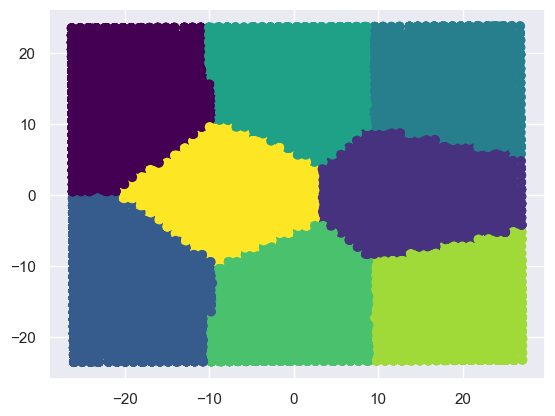

In [34]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')